<h1>Compact Programming Language Detector Comparison</h1>

The following is a comparison of two open source librarys that can perform Programming Language Detection. 

<h3>Choosing</h3> 

While deciding on whic two librarys I want to compare I considered the following options:

<ol>
    <li>Linguist(Github)</li>
    <li>Enry</li>
    <li>Pygments</li>
    <li>Guesslang(Microsoft/VSCode)</li>
</ol>

Linguist is used by Github to detect files in a repository. It's written in Ruby and I discovered that it takes a significant amount of time to load the linguist Gem file (around 2 seconds on a modern Ryzen7 processor with a NVME ssd). It uses a number of different approaches to define a list of candidate languages that it feeds into a Bayes classifier to make a final prediction. 

Enry is a golang port of Linguist why it works virtually the same but it runs faster. 

Pygments is primarily used as a code higlighter but it has the capability to predict the language of the sourcecode. After trying it out on a small portion of my test data I observed that the prediction was wrong most of the time. That's why I didn't consider it any further. 

Lastly I tested out Guesslang which is used in VSCode to automaticly predict the language of a files. It uses a neural network to make the prediction and after testing it out I found it the most promising.

In conclusion I am choosing Enry over Linguist because of its edge in performance and the comparison will be between <b>Enry and Guesslang</b>. 

<h3>Imports and helper functions:</h3>

In [27]:
from wrappers.guesslang_wrapper import detect_guesslang
from wrappers.enry_wrapper import detect_enry

import os
from collections import defaultdict

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

# load paths to data
paths = defaultdict(list)
data_path = "./test_data/"

for dir in os.listdir(data_path):
    for file in os.listdir(data_path + dir):
        paths[dir].append(data_path + dir + "/" + file)

ground_truth = []
paths_flat = []

for k in paths:
    for p in paths[k]:
        ground_truth.append(k)
        paths_flat.append(p)

def accuracy(preds, gtruth):
    wrongly_classified_idcs = []

    for idx, t in enumerate(gtruth):
        if t != preds[idx]:
            wrongly_classified_idcs.append(idx)

    return "Accuracy: " + str(1 - len(wrongly_classified_idcs) / len(gtruth)) 

def plot_conf_matrix(ground_truth, preds):
    preds_clean = [p if p in paths.keys() else "Other" for p in preds]
    labels = set(preds_clean)
    
    # clean preds
    M = confusion_matrix(ground_truth, preds_clean, normalize="true", labels=list(labels))
    
    plt.figure(figsize=(10,7))
    plt.matshow(M, cmap=plt.cm.gray_r, aspect='auto', fignum=1)
    plt.colorbar()
    tick_marks = np.arange(M.shape[0])
    plt.xticks(tick_marks, set(preds_clean), rotation=90)
    plt.yticks(tick_marks, set(preds_clean))
    plt.grid()
    
    for idx, r in enumerate(M):
#         print(str(list(labels)[idx]) + ": " + str(r[idx]))
        print('{:<30}{:<30}'.format(list(labels)[idx], r[idx]))

In the comparison we will consider two usecases. For the first usecase we consider a setting where we have a repository of files with the according file extensions.
In the second scenario we assume that we only have a snippet of code without any further information and we want to classify the language only based on the sourcecode.
### Case 1 (File extensions given):

Enry ran in 1 seconds.
Accuracy: 0.9993144708961735
TypeScript                    1.0                           
Java                          1.0                           
Swift                         0.999                         
Julia                         1.0                           
Other                         0.0                           
Dart                          1.0                           
Python                        1.0                           
JavaScript                    0.998998998998999             
Scala                         1.0                           
Lua                           1.0                           
C                             1.0                           
Go                            1.0                           
Kotlin                        1.0                           
Clojure                       1.0                           
Ruby                          0.998998998998999             
C++                           1.0

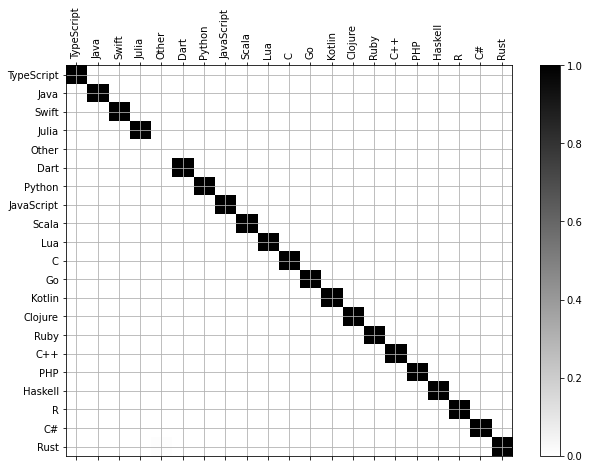

In [28]:
# Make predcitions enry
preds_enry = [p.decode("utf-8") for p in detect_enry(paths_flat, no_ext=False)]
print(accuracy(preds_enry, ground_truth))
plot_conf_matrix(ground_truth, preds_enry)

For the first usecase, Enry runs extremely fast while making virtually no classification errors. I assume that is due to the fact that it relys heavily on the given file extensions and almost never falls back on the Bayes classifier, which would also explain the short runtime. We will test this in the second usecase.

100%|████████████████████████████████████| 16046/16046 [00:32<00:00, 497.86it/s]


Guesslang ran in 33 seconds.
Accuracy: 0.7856163529851676
TypeScript                    0.5125125125125125            
Java                          0.6882716049382716            
Swift                         0.525                         
Julia                         0.851                         
Other                         0.0                           
Dart                          0.33076923076923076           
Python                        0.92                          
JavaScript                    0.5345345345345346            
Scala                         0.876                         
Lua                           0.8952879581151832            
C                             0.345                         
Go                            0.913                         
Kotlin                        0.878                         
Ruby                          0.8548548548548549            
Clojure                       0.997275204359673             
C++                        

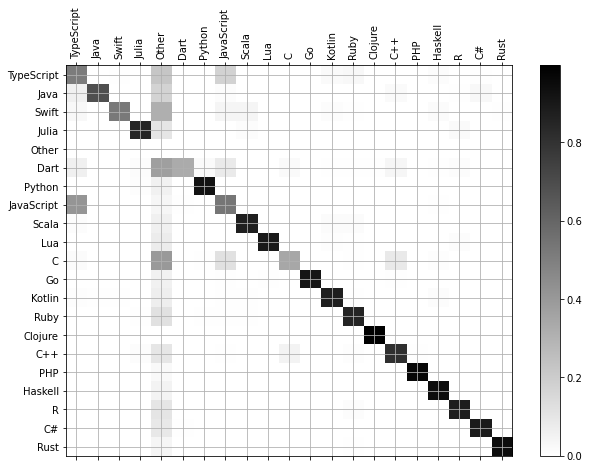

In [30]:
# Make predcitions guesslang
preds_guesslang = detect_guesslang(paths_flat)
print(accuracy(preds_guesslang, ground_truth))
plot_conf_matrix(ground_truth, preds_guesslang)

For Guesslang we have a significantly lower test accuracy of ##fill in## with a noticably slower runtime but that is not surprising because we now Guesslang makes predictions solely on the sourcecode.
We have a accuracy below 80% for the following languages:

<b>Javascript/Typescript</b> - We can see that Javascript is often times cofused for TypeScript and vice versa. This was expected because JavaScript is a subset of TypeScript so a valid script in JavaScript is also valid in TypeScript.

<b>C</b>

<b>Dart</b>

<b>Swift</b>

<b>Java</b>

We can see that Enry has a much higher accuracy. That is due to the fact that it uses a sequence of matching strategies like extracting the file extention from the filename or extracting information from a shebang to narrow down the number of possible mathces before falling back on a the Bayesian clasifier. That greatly increases the acuracy and speed in this particualr usecase. Guesslang uses a neural-network instead, to predict a language amongst 50 possible classes, only using the sourcecode as its input feautures. 

<h3>Case 2 (no file extension):</h3>

For the second use case, we assume we only have the sourcecode available without the file extension. Since Guesslang doesn't consider any other feautures than the code itself, we only rerun the Enry classifyer, but this time with the <b>no-ext</b> flag.

<font color='red'>Warning: The following cell runs for around 200 seconds</font>

Enry ran in 201 seconds.
Accuracy: 0.42147575719805563
TypeScript                    0.009009009009009009          
Java                          0.4506172839506173            
Swift                         0.244                         
Julia                         0.01                          
Other                         0.0                           
Dart                          0.0                           
Python                        0.836                         
JavaScript                    0.46646646646646645           
Scala                         0.343                         
Lua                           0.6701570680628273            
C                             0.55                          
Go                            0.001                         
Kotlin                        0.037                         
Clojure                       0.2111716621253406            
Ruby                          0.7567567567567568            
C++                           

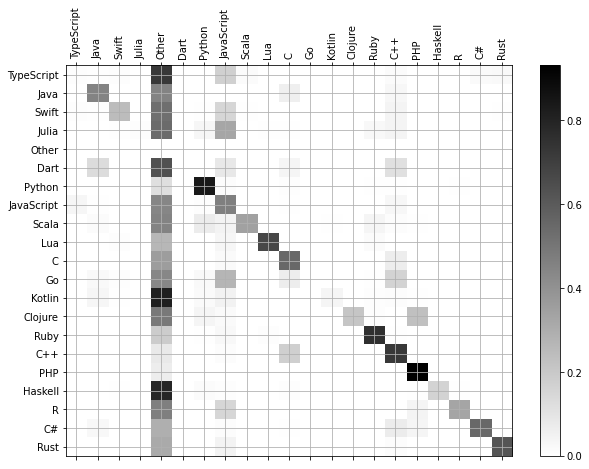

In [32]:
preds_enry_no_ext = [p.decode("utf-8") for p in detect_enry(paths_flat, no_ext=True)]
print(accuracy(preds_enry_no_ext, ground_truth))
plot_conf_matrix(ground_truth, preds_enry_no_ext)

This time Enry runs very slow and the accuracy is only ##fill in## percent. 

Over 80 club: 

Python

PHP

(Ruby)

<h2>Conclusion</h2>

In the Project description CPLD is defined as

<b>"... the task of guessing a programming language by looking at the snippet of source code text."</b>

so the second usecase is the one fitting for our task. Enrys performance relys heavily on wether it's matching startegies are applicable and if not so, it falls way behind Linguist in accuracy and even runtime.
Linguist has a reasonable runtime and an average acuracy of almost 80% and although it shows some confusion when it comes to differentiating between similar languages it outperforms Enry by far.